# Contribution Scores using DeepLift

Try to get DeepLift to work, somehow...

In [120]:
# Must restart the kernel for this
from deepexplain.tensorflow import DeepExplain
import modisco
from deeplift.dinuc_shuffle import dinuc_shuffle, traverse_edges, shuffle_edges, prepare_edges
from collections import Counter
from deeplift.visualization import viz_sequence
import shap
import shap.explainers.deep.deep_tf

from importlib import reload
import re
import random
from pathlib import Path
random.seed(1337)
import os
import pickle
from decimal import Decimal

import numpy as np
np.random.seed(1337)
import pandas as pd
pd.options.mode.chained_assignment = None 
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib_config
import seaborn as sns

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

import utils_data
import model

TF-MoDISco is using the TensorFlow backend.


In [3]:
from bpnet.cli.contrib import ContribFile
from bpnet.plot.tracks import plot_tracks, to_neg
from concise.utils.plot import seqlogo

Instructions for updating:
Colocations handled automatically by placer.


2021-02-02 15:56:20,497 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [161]:
# get input sequences
one_hot = utils_data.OneHotEncoder("utr")
with open(Path("../Data/data_dict.pkl"), 'rb') as handle:
    data_dict = pickle.load(handle)
mpra_data = data_dict["mpra"]
mpra_data_varlen = data_dict["varlen_mpra"]
val_data = mpra_data[(mpra_data.library == "human")]
onehot_data = one_hot(val_data)

# Rebuild model, without any masking

In [6]:
utr_model = load_model("../Models/utr_model_50.h5", 
                   custom_objects={'FrameSliceLayer': model.FrameSliceLayer})

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2021-02-02 16:06:35,717 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.cast instead.


2021-02-02 16:06:38,700 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


2021-02-02 16:06:38,840 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [7]:
utr_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_seq (InputLayer)          (None, None, 4)      0                                            
__________________________________________________________________________________________________
convolution_0 (Conv1D)          (None, None, 128)    3712        input_seq[0][0]                  
__________________________________________________________________________________________________
compute_pad_mask (Lambda)       (None, None)         0           input_seq[0][0]                  
__________________________________________________________________________________________________
apply_pad_mask_0 (Lambda)       (None, None, 128)    0           convolution_0[0][0]              
                                                                 compute_pad_mask[0][0]           
__________

In [71]:
import keras
from keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Dropout, Concatenate, Lambda, Flatten, ZeroPadding1D, MaxPooling1D, BatchNormalization, ThresholdedReLU, Masking, Add, LSTM, SpatialDropout1D
from keras.models import Model
from keras.layers import Layer
from keras import losses
from keras import backend as K
import tensorflow as tf

class FrameSliceLayer(Layer):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape) 
    
    def call(self, x):
        shape = K.shape(x)
        x = K.reverse(x, axes=1) # reverse, so that frameness is related to fixed point (start codon)
        frame_1 = tf.gather(x, K.arange(start=0, stop=shape[1], step=3), axis=1)
        frame_2 = tf.gather(x, K.arange(start=1, stop=shape[1], step=3), axis=1)
        frame_3 = tf.gather(x, K.arange(start=2, stop=shape[1], step=3), axis=1)
        return [frame_1, frame_2, frame_3]
    
    def compute_output_shape(self, input_shape):
        if len(input_shape) == 2:
            return [(input_shape[0], None),(input_shape[0], None),(input_shape[0], None)]
        return [(input_shape[0], None, input_shape[2]),(input_shape[0], None, input_shape[2]),(input_shape[0], None, input_shape[2])]

def recreate_frame_slice_model():
    # Inputs
    input_seq = Input(shape=(50, 4), name="input_seq")
    inputs = input_seq
    conv_features = input_seq
    # Convolution
    layer_list = []
    for i in range(3):
        conv_features_shortcut = conv_features #shortcut connections
        conv_features = Conv1D(filters=128, kernel_size=7, dilation_rate=1, activation='relu', 
                           padding="same", name="convolution_"+str(i))(conv_features)
        if i > 0:
            conv_features = Add(name="add_residual_"+str(i))([conv_features, conv_features_shortcut])
    # Frame based masking    
    frame_masked_features = FrameSliceLayer(name="frame_masking")(conv_features)
    # Pooling
    pooled_features = []
    max_pooling = GlobalMaxPooling1D(name="pool_max_frame_conv")
    avg_pooling = GlobalAveragePooling1D(name="pool_avg_frame_conv")
    pooled_features = pooled_features + \
                    [max_pooling(frame_masked_features[i]) for i in range(len(frame_masked_features))]
    pooled_features = pooled_features + [avg_pooling(frame_masked_features[i]) for i in range(len(frame_masked_features))]
    pooled_features = Concatenate(axis=-1, name="concatenate_pooled")(pooled_features)
    # Add tis_context if necessary
    concat_features = pooled_features
    # Prediction (Dense layer)
    predict = concat_features
    for i in range(1):
        predict = Dense(64, activation='relu', name="fully_connected_"+str(i))(predict)
        predict = Dropout(rate=0.2, name="fc_dropout_"+str(i))(predict)
    predict = Dense(1, name="mrl_output_unscaled")(predict) 
    """ Model """
    model = Model(inputs=inputs, outputs=predict)
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss="mean_squared_error", optimizer=adam)
    return model

In [72]:
utr_model_no_masking = recreate_frame_slice_model()

In [73]:
utr_model_no_masking.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_seq (InputLayer)          (None, 50, 4)        0                                            
__________________________________________________________________________________________________
convolution_0 (Conv1D)          (None, 50, 128)      3712        input_seq[0][0]                  
__________________________________________________________________________________________________
convolution_1 (Conv1D)          (None, 50, 128)      114816      convolution_0[0][0]              
__________________________________________________________________________________________________
add_residual_1 (Add)            (None, 50, 128)      0           convolution_1[0][0]              
                                                                 convolution_0[0][0]              
__________

In [74]:
# Set weights of new model to .ipynb_checkpoints/eights of the old one
# conv 0
utr_model_no_masking.layers[1].set_weights(utr_model.layers[1].get_weights())
# conv 1
utr_model_no_masking.layers[2].set_weights(utr_model.layers[4].get_weights())
# conv 2
utr_model_no_masking.layers[4].set_weights(utr_model.layers[6].get_weights())
# fully connected
utr_model_no_masking.layers[10].set_weights(utr_model.layers[12].get_weights())
# mrl output
utr_model_no_masking.layers[12].set_weights(utr_model.layers[14].get_weights())

In [75]:
# Test
test_data = mpra_data[(mpra_data.set == "test") & (mpra_data.library == "egfp_unmod_1")]
onehot_test = one_hot(test_data)
y = test_data["rl"]
print(stats.pearsonr(utr_model.predict(onehot_test).reshape(-1), test_data["rl"]))
print(stats.pearsonr(utr_model_no_masking.predict(onehot_test).reshape(-1), test_data["rl"]))
#test_data = mpra_data_varlen[(mpra_data_varlen.len == 100)]
#onehot_test = one_hot(test_data)
#y = test_data["rl"]
#print(stats.pearsonr(utr_model.predict(onehot_test).reshape(-1), test_data["rl"]))
#print(stats.pearsonr(utr_model_no_masking.predict(onehot_test).reshape(-1), test_data["rl"]))

(0.9636863276977199, 0.0)
(0.9318246454191366, 0.0)


Close enough.....

In [76]:
utr_model_no_masking.save("../Models/utr_model_contribution_fixed_size.h5")

# **DeepExplain**

In [162]:
def plot_logo(arr, name="", fig_dims = (6.0, 1.5)):
    fig,ax = plt.subplots()
    seqlogo(arr, vocab="RNA", ax=ax)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_ylim(-1.0, 1.0)
    #ax.set_ylabel("")
    #ax.tick_params(axis='both', which='major', labelsize=10)

    sns.despine(fig, bottom=True, left=True)
    fig.set_size_inches(fig_dims)
    #fig.savefig(Path("../Graphics/motifs/" + name +".svg"))

In [163]:
def explain_deeply(encoded_df, batchsize=64, baseline=np.zeros((50,4))):
    K.clear_session()
    sess = K.get_session()
    with DeepExplain(session=sess) as de:
        utr_model = load_model("../Models/utr_model_contribution_fixed_size.h5", 
                   custom_objects={'FrameSliceLayer': model.FrameSliceLayer})
        input_tensor = utr_model.layers[0].input
        target_tensor = utr_model(input_tensor)
        return de.explain('deeplift', target_tensor, input_tensor, encoded_df, batch_size=batchsize, baseline=baseline)

In [164]:
attrib = explain_deeply(onehot_data)

2021-02-02 21:41:51,855 [INFO] DeepExplain: running "deeplift" explanation method (5)
2021-02-02 21:41:51,859 [INFO] Model with multiple inputs: False


In [166]:
utr_model = load_model("../Models/utr_model_contribution_fixed_size.h5", 
                   custom_objects={'FrameSliceLayer': model.FrameSliceLayer})
input_tensor = utr_model.layers[0].input
target_tensor = utr_model(input_tensor)
fn = K.function([input_tensor], K.gradients(target_tensor, input_tensor))
grad = fn([onehot_data])[0]
#grad_list = []
#for i in range(32):
#    grad_list.append(fn([onehot_data[(7500*i):(7500*(i+1))]])[0])
#grad = np.concatenate(grad_list,axis=0)    

# **Modisco**

In [167]:
task_to_scores = {}
task_to_hyp_scores = {}
task_to_scores["mrl"] = attrib
task_to_hyp_scores["mrl"] = grad

MEMORY 10.230370304
On task mrl
Computing windowed sums on original
Generating null dist
peak(mu)= -0.20393391869962216
Computing threshold
Thresholds from null dist were -1.91081140935421  and  1.5313785076141357
Passing windows frac was 0.012741463414634146 , which is below  0.03 ; adjusting
Final raw thresholds are -1.4166954314708713  and  1.4166954314708713
Final transformed thresholds are -0.97  and  0.97


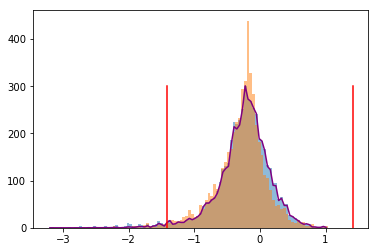

Got 4314 coords
After resolving overlaps, got 4314 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9699999
MEMORY 10.237054976
4314 identified in total
1 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  [4295]
Idx to activities:  {0: '-1'}
MEMORY 10.23746048
On metacluster 0
Metacluster size 4295
Relevant tasks:  ('mrl',)
Relevant signs:  (-1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 4295
(Round 1) Computing coarse affmat
MEMORY 10.237198336
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.81 s
Starting affinity matrix computations
Normalization computed in 0.04 s
Cosine similarity mat computed in 0.23 s
Normalization computed in 0.03 s
Cosine similarity mat computed in 0.2 s
Finished affinity matrix computations in 0.44 s
(Round 1) Compute nearest neighbors from coarse affmat
MEMORY 10.310995968
Computed nearest neighbors in 0.56 s
MEMORY 10.310995968
(Round 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   12.8s finished


Louvain completed 200 runs in 17.9478657245636 seconds
Wrote graph to binary file in 10.114474773406982 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.772986
After 5 runs, maximum modularity is Q = 0.773974
After 48 runs, maximum modularity is Q = 0.774526
Louvain completed 98 runs in 60.69678854942322 seconds
Preproc + Louvain took 90.19590497016907 s
Got 14 clusters after round 1
Counts:
{0: 392, 9: 148, 6: 271, 5: 284, 7: 224, 4: 284, 11: 26, 3: 290, 8: 213, 2: 324, 10: 96, 13: 19, 12: 21, 1: 341}
MEMORY 10.18359808
(Round 1) Aggregating seqlets in each cluster
MEMORY 10.18359808
Aggregating for cluster 0 with 392 seqlets
MEMORY 10.18359808
Trimmed 5 out of 392
Skipped 259 seqlets
Aggregating for cluster 1 with 341 seqlets
MEMORY 10.18359808
Trimmed 25 out of 341
Skipped 159 seqlets
Aggregating for cluster 2 with 324 seqlets
MEMORY 10.18359808
Trimmed 10 out of 324
Skipped 196 seqlets
Aggregating for cluster 3 with 290 seqlets
MEMORY 10.183

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.1s finished


Louvain completed 200 runs in 4.228327989578247 seconds
Wrote graph to binary file in 1.0051722526550293 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.737164
After 21 runs, maximum modularity is Q = 0.743
Louvain completed 71 runs in 28.363696336746216 seconds
Preproc + Louvain took 34.1990110874176 s
Got 9 clusters after round 2
Counts:
{5: 103, 1: 167, 6: 69, 8: 58, 3: 122, 4: 115, 0: 194, 2: 157, 7: 62}
MEMORY 10.183929856
(Round 2) Aggregating seqlets in each cluster
MEMORY 10.183929856
Aggregating for cluster 0 with 194 seqlets
MEMORY 10.183929856
Trimmed 2 out of 194
Aggregating for cluster 1 with 167 seqlets
MEMORY 10.183929856
Trimmed 1 out of 167
Aggregating for cluster 2 with 157 seqlets
MEMORY 10.183929856
Trimmed 11 out of 157
Aggregating for cluster 3 with 122 seqlets
MEMORY 10.183917568
Trimmed 17 out of 122
Aggregating for cluster 4 with 115 seqlets
MEMORY 10.183917568
Trimmed 10 out of 115
Aggregating for cluster 5 with 103 se

In [ ]:
null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    sliding_window_size=10,
                    flank_size=5,
                    target_seqlet_fdr=0.2,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=10,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=1,
                        final_min_cluster_size=30)
                )(
                 task_names=["mrl"],
                 contrib_scores=task_to_scores,
                 hypothetical_contribs=task_to_hyp_scores,
                 one_hot=onehot_data,
                 null_per_pos_scores = null_per_pos_scores)

In [175]:
import h5py
import modisco.util
grp = h5py.File("../Data/Contributions/results_human_deeplift.hdf5", "w")
tfmodisco_results.save_hdf5(grp)
grp.close()

Metaclusters heatmap


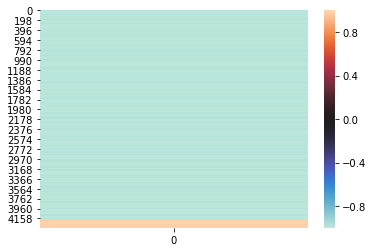

metacluster_0
activity pattern: [-1]
metacluster_0 pattern_0
total seqlets: 304
MRL hypothetical scores:


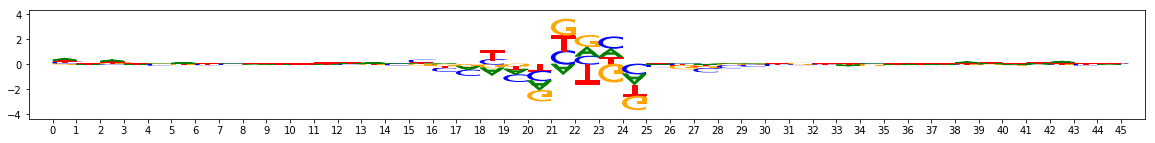

MRL actual importance scores:


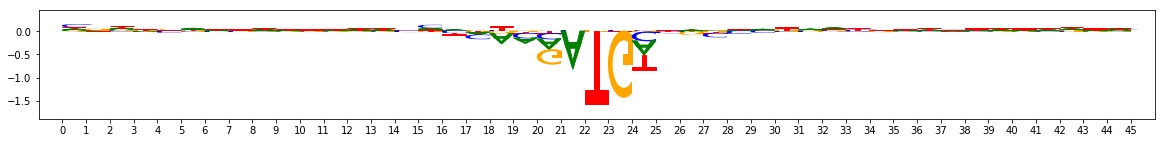

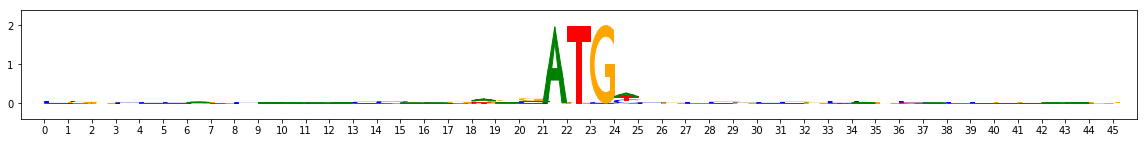

metacluster_0 pattern_1
total seqlets: 48
MRL hypothetical scores:


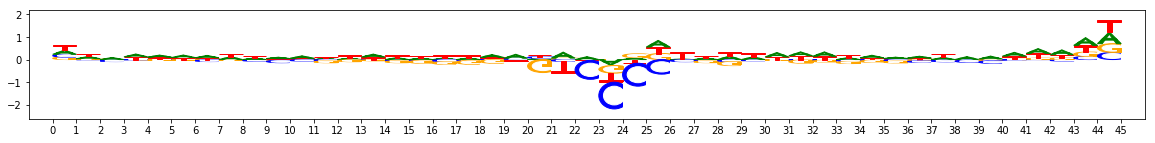

MRL actual importance scores:


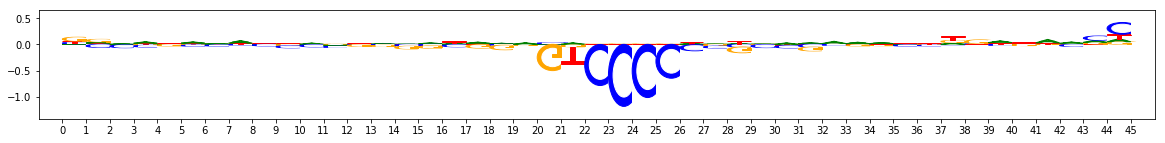

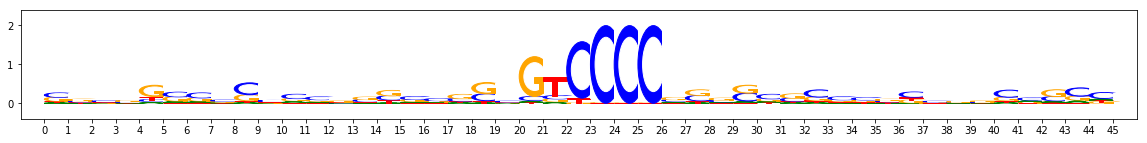

metacluster_0 pattern_2
total seqlets: 91
MRL hypothetical scores:


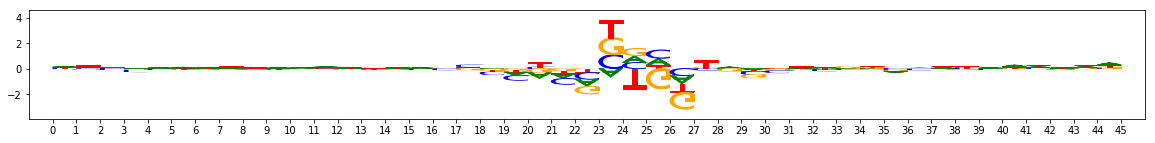

MRL actual importance scores:


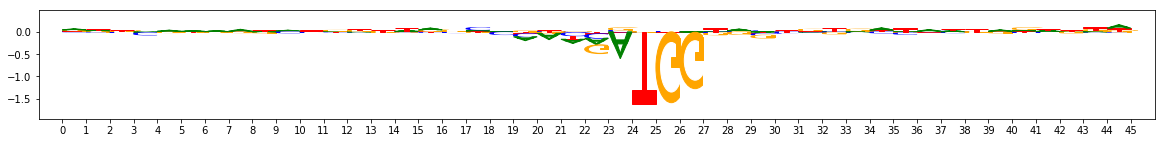

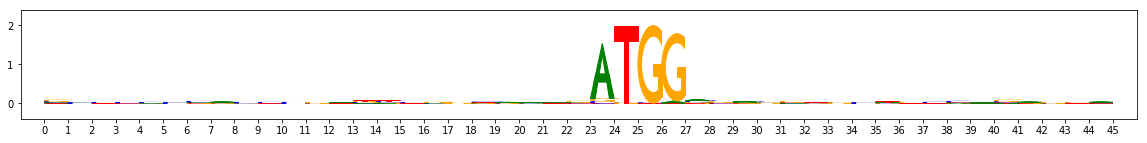

metacluster_1
activity pattern: [1]
No motifs found for this activity pattern


In [176]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("../Data/Contributions/results_human.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []
background = np.array([0.27, 0.23, 0.23, 0.27])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        print("MRL hypothetical scores:")
        viz_sequence.plot_weights(pattern["mrl_hypothetical_contribs"]["fwd"])
        print("MRL actual importance scores:")
        viz_sequence.plot_weights(pattern["mrl_contrib_scores"]["fwd"])
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        
hdf5_results.close()